In [1]:
# Third-party
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Custom
import gala.coordinates as gc
import gala.dynamics as gd
from gala.dynamics.mockstream import fardal_stream, streakline_stream
import gala.integrate as gi
import gala.potential as gp
from gala.units import galactic
from matplotlib import cm
from scipy.optimize import minimize

from potential import default_mw
from coordinates import galcen_frame, pal5_c

from density import DensityModel2D, get_projected_coords
from likelihood import a_to_z, Model

Make a mock stream model for testing:

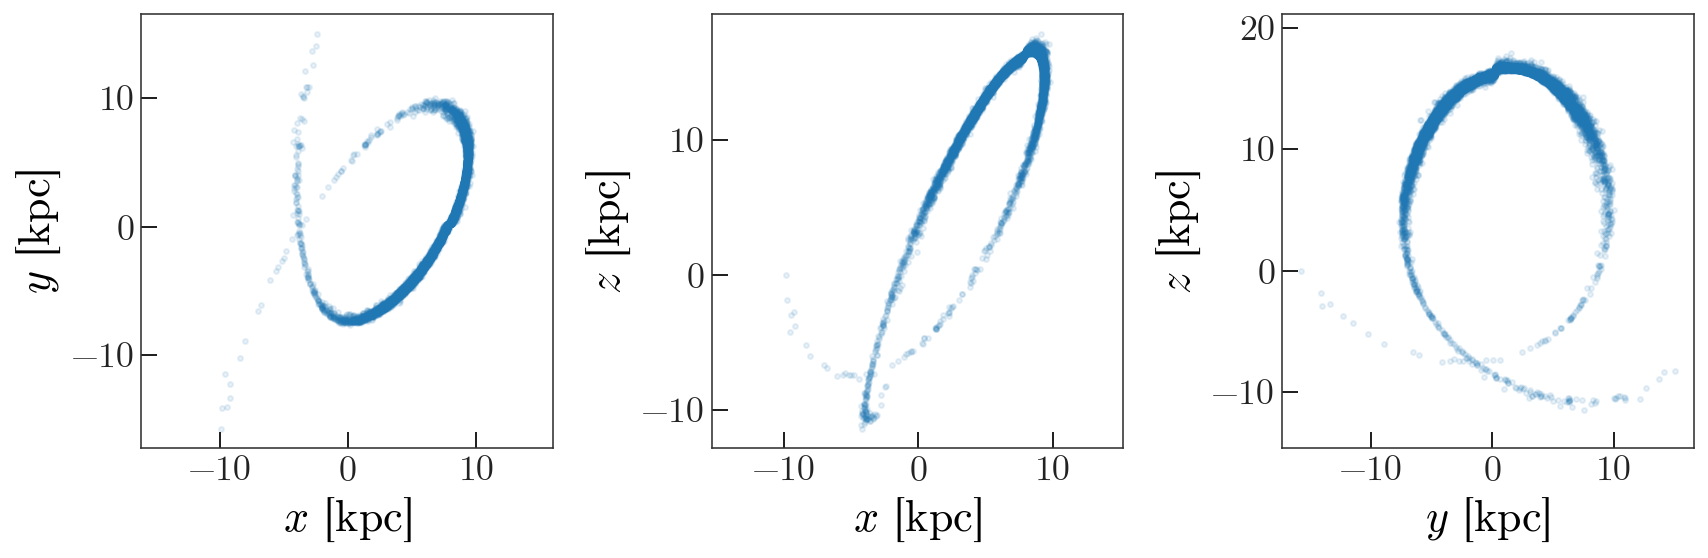

In [2]:
w0 = gd.PhaseSpacePosition(pal5_c.transform_to(galcen_frame).cartesian)
orbit = default_mw.integrate_orbit(w0, dt=-0.5, n_steps=8000, 
                                   Integrator=gi.DOPRI853Integrator)

stream = gd.mockstream.fardal_stream(default_mw, orbit[::-1], 
                                     5E4*u.Msun, release_every=1)
_ = stream.plot(marker='.', alpha=0.1)

We're going to do density fitting in Pal5 coordinates:

In [3]:
sim_c = stream.to_coord_frame(gc.Pal5, galactocentric_frame=galcen_frame)

# Only grab data within bounds:
lon_limits = [-50, 50]*u.deg
lat_limits=[-10, 40]*u.deg

mask = ((sim_c.phi1.wrap_at(180*u.deg) > lon_limits[0]) &
        (sim_c.phi1.wrap_at(180*u.deg) < lon_limits[1]) & 
        (sim_c.phi2 > lat_limits[0]) &
        (sim_c.phi2 < lat_limits[1]))
sim_c = sim_c[mask]

In [4]:
X = get_projected_coords(sim_c, pal5_c).T
mask = (X[:, 0] > -1) & (X[:, 1] > -1)
X = X[mask]

In [5]:
spacing = 1.5 # MAGIC NUMBER
dens_model = DensityModel2D(X, poly_deg=5)
track = dens_model.get_dense_poly_track(size=10000)
nodes = dens_model.set_nodes(track=track, spacing=spacing)
# nodes = dens_model.set_nodes(track=track, nodes=nodes[1:-1])

(-5, 40)

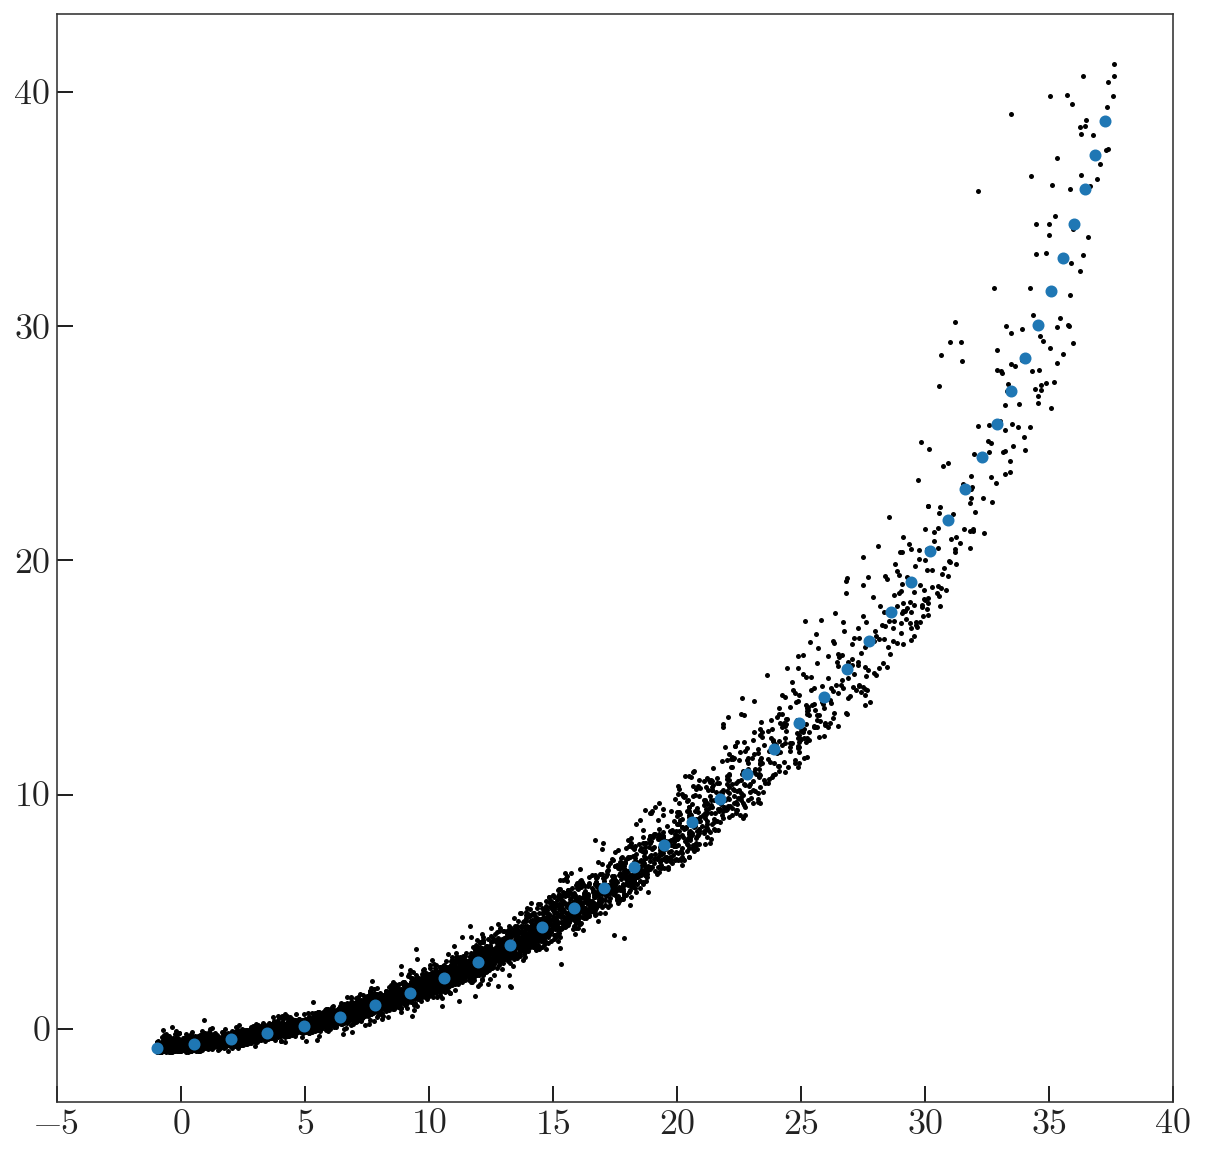

In [6]:
plt.figure(figsize=(10, 10))
plt.scatter(nodes[:, 0], nodes[:, 1])
plt.plot(dens_model.X[:, 0], dens_model.X[:, 1], 
         marker='.', ls='none', alpha=1, zorder=-10, color='k')
plt.xlim(-5, 40)

In [7]:
bins = (np.linspace(-5, 45, 250),
        np.linspace(-5, 45, 250))
bincs = [0.5*(x[1:]+x[:-1]) for x in bins]
xg, yg = np.meshgrid(*bincs)
X_grid = np.stack((xg.ravel(), yg.ravel())).T

## Optimize:

In [8]:
h = 0.5 * spacing
model = Model(dens_model, h=h, l=2.5)

In [9]:
K = dens_model.K
print(K)

40


In [10]:
sk0 = 0.5 * np.ones(K)

a0 = np.ones(K)/K
z0 = a_to_z(a0)

m0 = np.zeros(K)

In [11]:
p0 = {'ln_s': np.log(sk0),
      'ln_z': np.log(z0),
      'm': m0}
x0 = model.pack_pars(**p0)
model.ln_posterior(x0)

-35571.831528919785

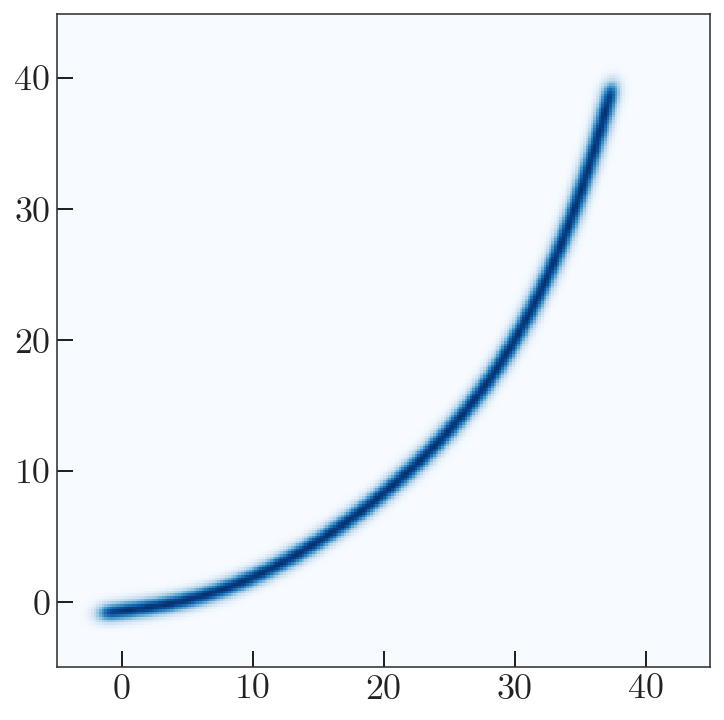

In [12]:
ln_dens = model.ln_density(p0, X_grid)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.pcolormesh(xg, yg, np.exp(ln_dens.reshape(xg.shape) - ln_dens.max()),
              cmap='Blues')
ax.set_aspect('equal')

In [13]:
def likelihood_helper(x):
    return -model.ln_posterior(x)

def deriv_helper(x):
    p = model.unpack_pars(x)
    return -model.derivs(p)

In [14]:
bounds = [[-8, 4]]*K + [[-8, -1e-9]]*(K-1) + [[-5, 5]]*K

res = minimize(likelihood_helper, jac=deriv_helper, 
               x0=x0, method='L-BFGS-B', 
               bounds=bounds,
               options=dict(ftol=1e-13))
res

      fun: 25853.48883522561
 hess_inv: <119x119 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.60259649e-02,  3.68717713e-02, -6.31706603e-02, -1.10441685e-01,
       -9.99194919e-02, -2.27467536e-01,  2.80751173e-01, -1.11798604e-01,
       -3.03152891e-01,  3.22492948e-02,  1.78254198e-02, -2.29171124e-01,
        7.84347694e-02,  7.82881300e-02,  5.95951145e-02,  5.81534802e-02,
       -9.01654407e-02, -3.08527721e-02, -6.15975006e-02, -4.44525028e-02,
       -2.03220148e-03,  9.72403638e-03,  1.84386900e-02,  2.35665418e-04,
       -1.28294225e-02,  1.91394287e-02,  7.47976443e-03,  5.72417541e-03,
        1.30039057e-03, -7.21707970e-09, -3.44432946e-03,  3.91457958e-02,
        2.36458187e-09,  4.74108161e-02,  6.60279954e-02, -4.02228513e-04,
       -1.30085948e-01, -1.57739713e-04, -2.50990722e-03, -3.07722621e-02,
        1.81656312e-01, -5.86563026e-02,  2.50135176e-02,  4.05633703e-02,
       -2.14628004e-02,  8.78628442e-02, -3.06064288e-02,  1.79372977e-01,


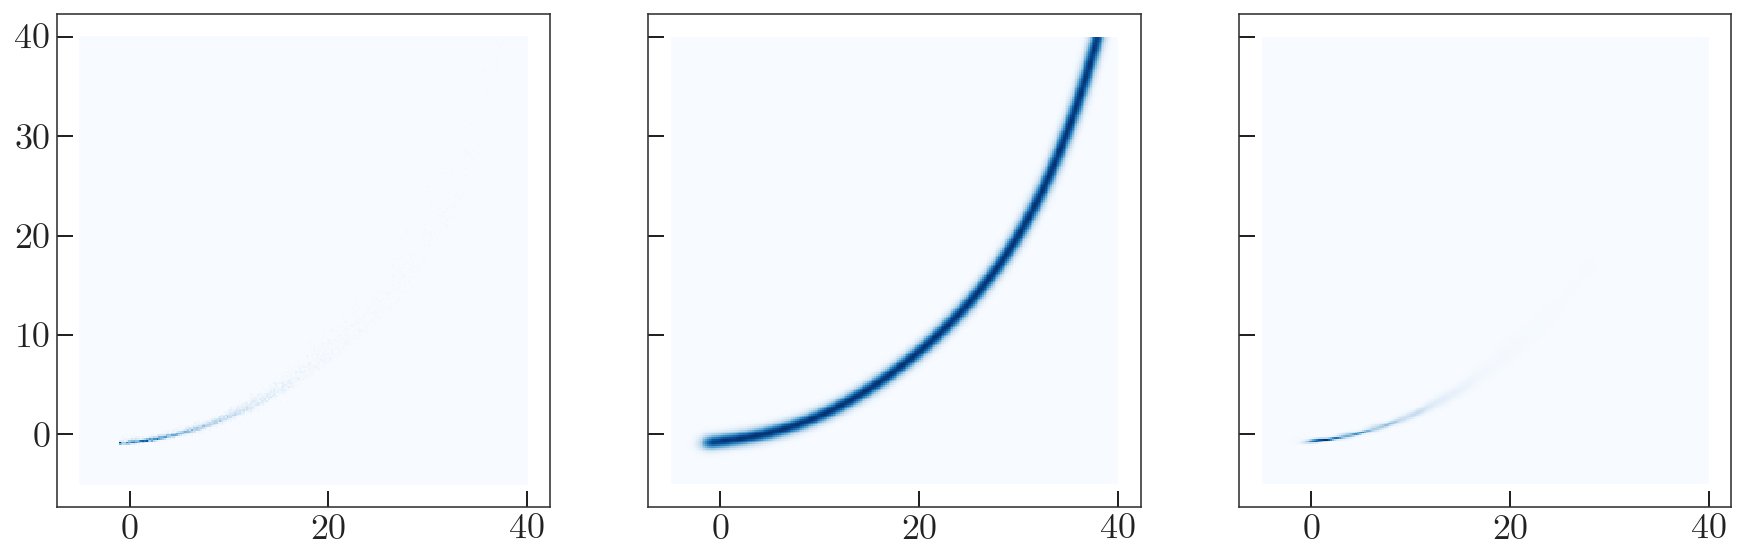

In [48]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5.5), 
                         sharex=True, sharey=True)

ax = axes[0]
# ax.plot(dens_model.proj_xy[0], dens_model.proj_xy[1], 
#         marker='.', ls='none', alpha=0.4, zorder=-10, color='k')
H,xe,ye = np.histogram2d(dens_model.X[:,0], dens_model.X[:,1],
                         bins=bins)
ax.pcolormesh(xe, ye, H.T, cmap='Blues')

ax = axes[1]
ln_dens = model.ln_density(p0, X_grid)
ax.pcolormesh(xg, yg, np.exp(ln_dens.reshape(xg.shape) - ln_dens.max()),
              cmap='Blues')

ax = axes[2]
best_p = model.unpack_pars(res.x)
ln_dens = model.ln_density(best_p, X_grid)
H2 = np.exp(ln_dens.reshape(xg.shape) - ln_dens.max())
ax.pcolormesh(xg, yg, H2,
              cmap='Blues')

for ax in axes:
    ax.set_aspect('equal')

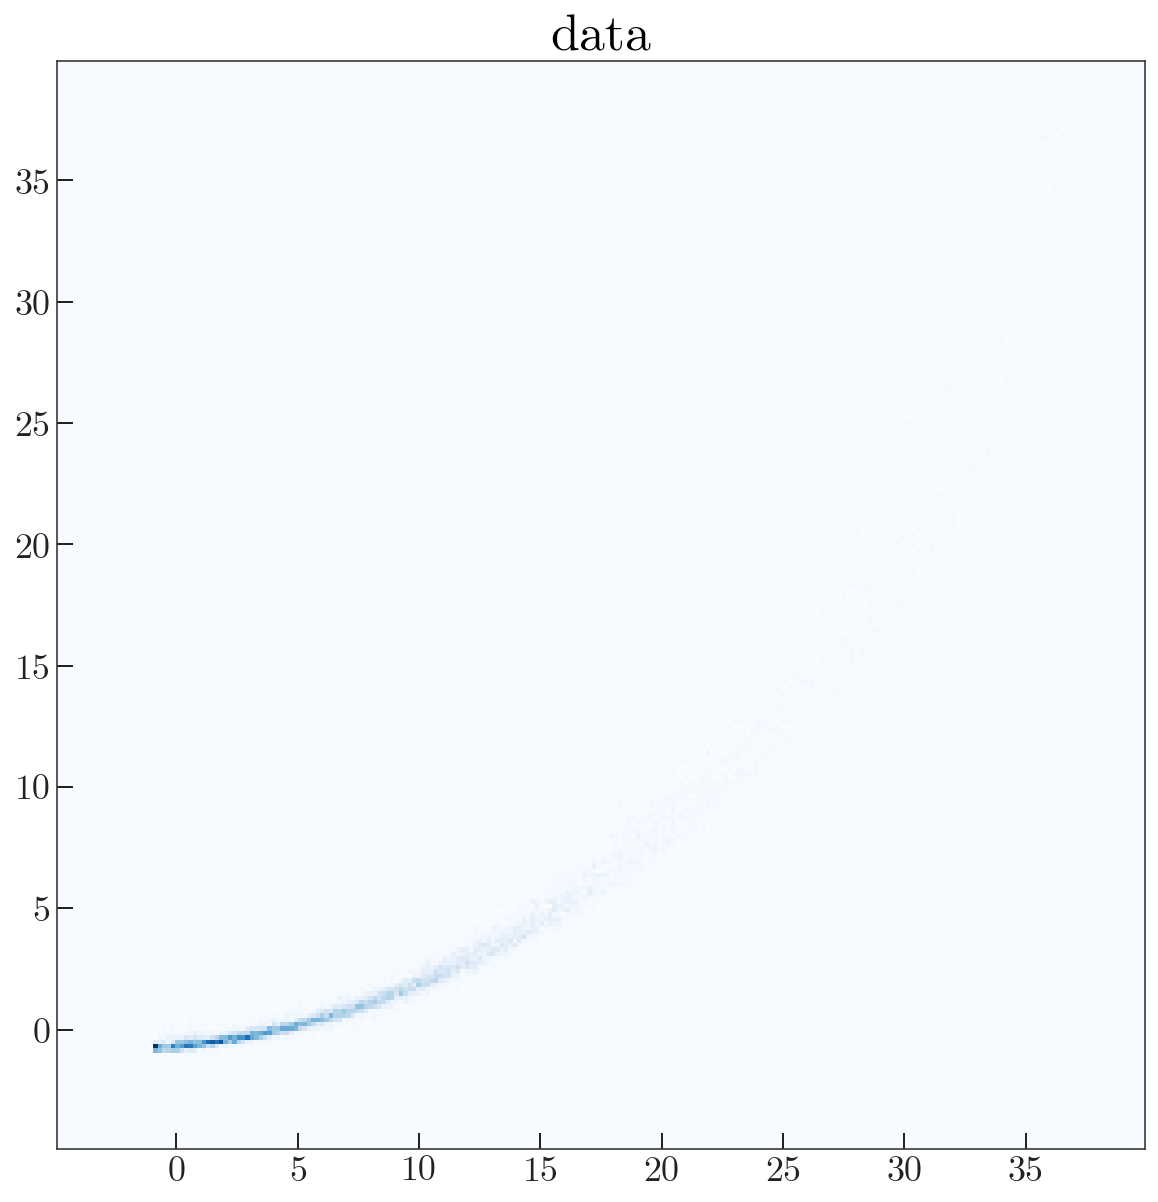

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.pcolormesh(xg, yg, H.T,
              cmap='Blues')
ax.set_aspect('equal')
ax.set_title('data')
fig.savefig('../plots/stream-data.png', dpi=250)

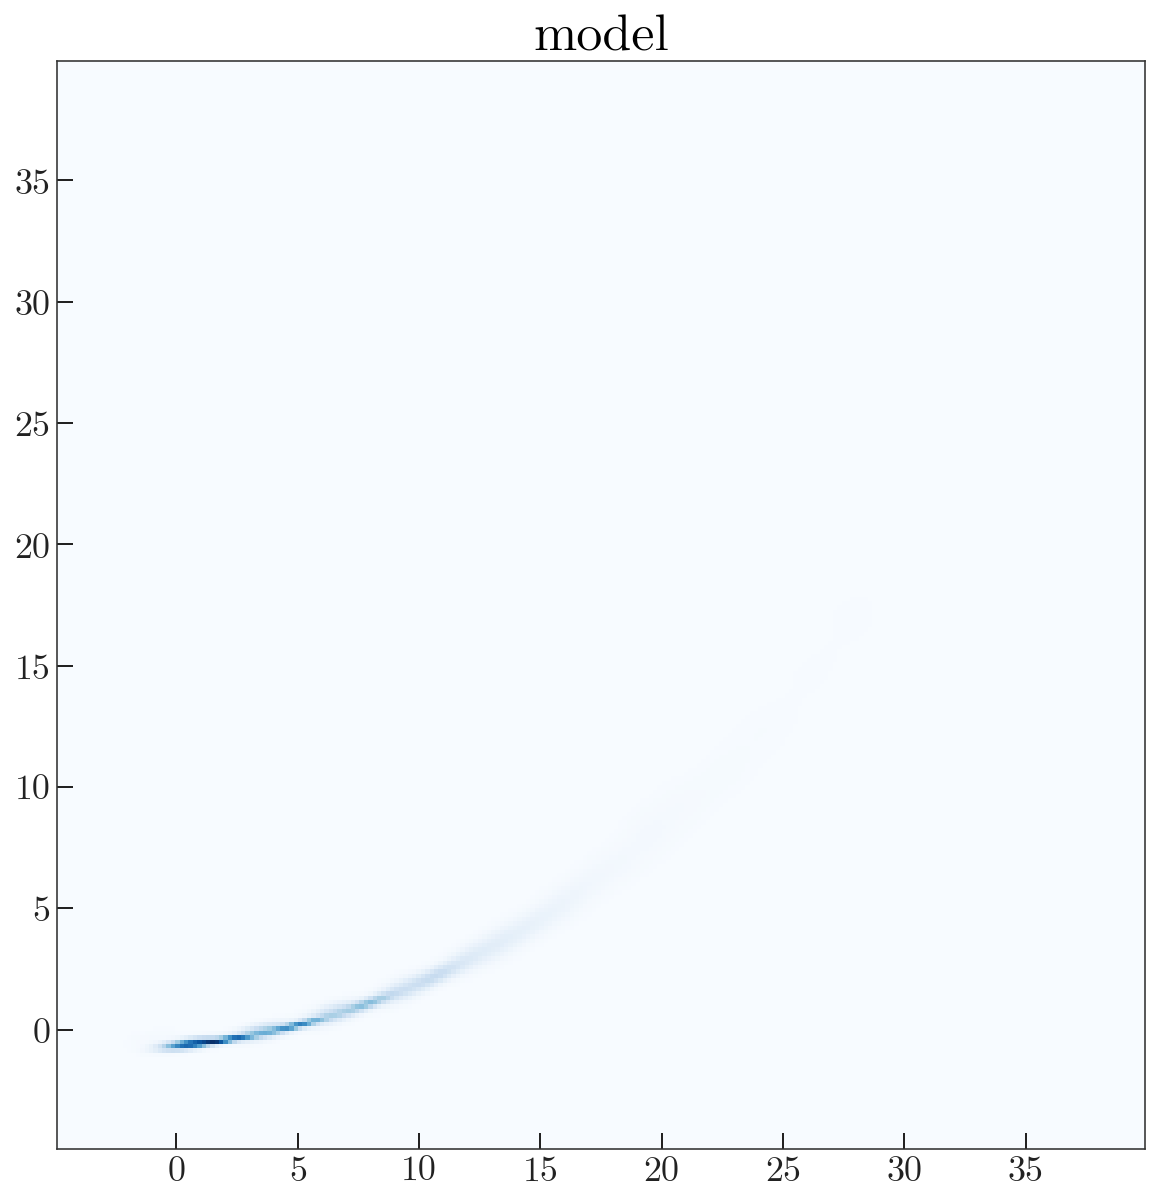

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.pcolormesh(xg, yg, H2,
              cmap='Blues')
ax.set_aspect('equal')
ax.set_title('model')
fig.savefig('../plots/stream-model.png', dpi=250)

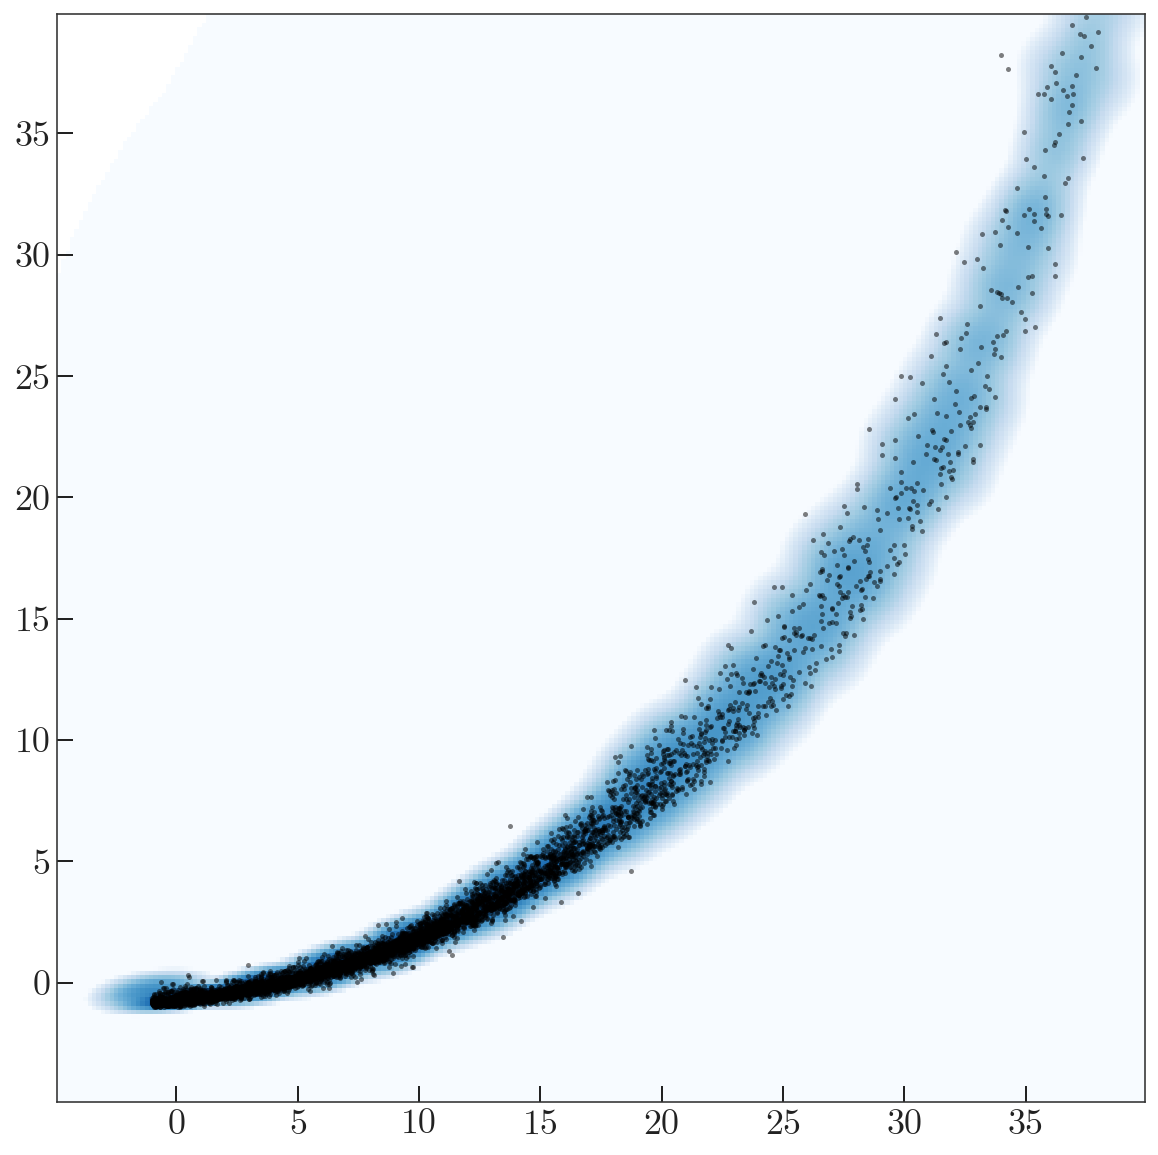

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.pcolormesh(xg, yg, H2,
              cmap='Blues', 
              norm=mpl.colors.LogNorm(vmin=1e-5, vmax=1e0))
ax.plot(X[:, 0], X[:, 1], 
        marker='.', ls='none', alpha=0.5, zorder=10, color='k')
ax.set_aspect('equal')
ax.set_xlim(bincs[0].min(), bincs[0].max())
ax.set_ylim(bincs[1].min(), bincs[1].max())
fig.savefig('../plots/stream-compare.png', dpi=250)

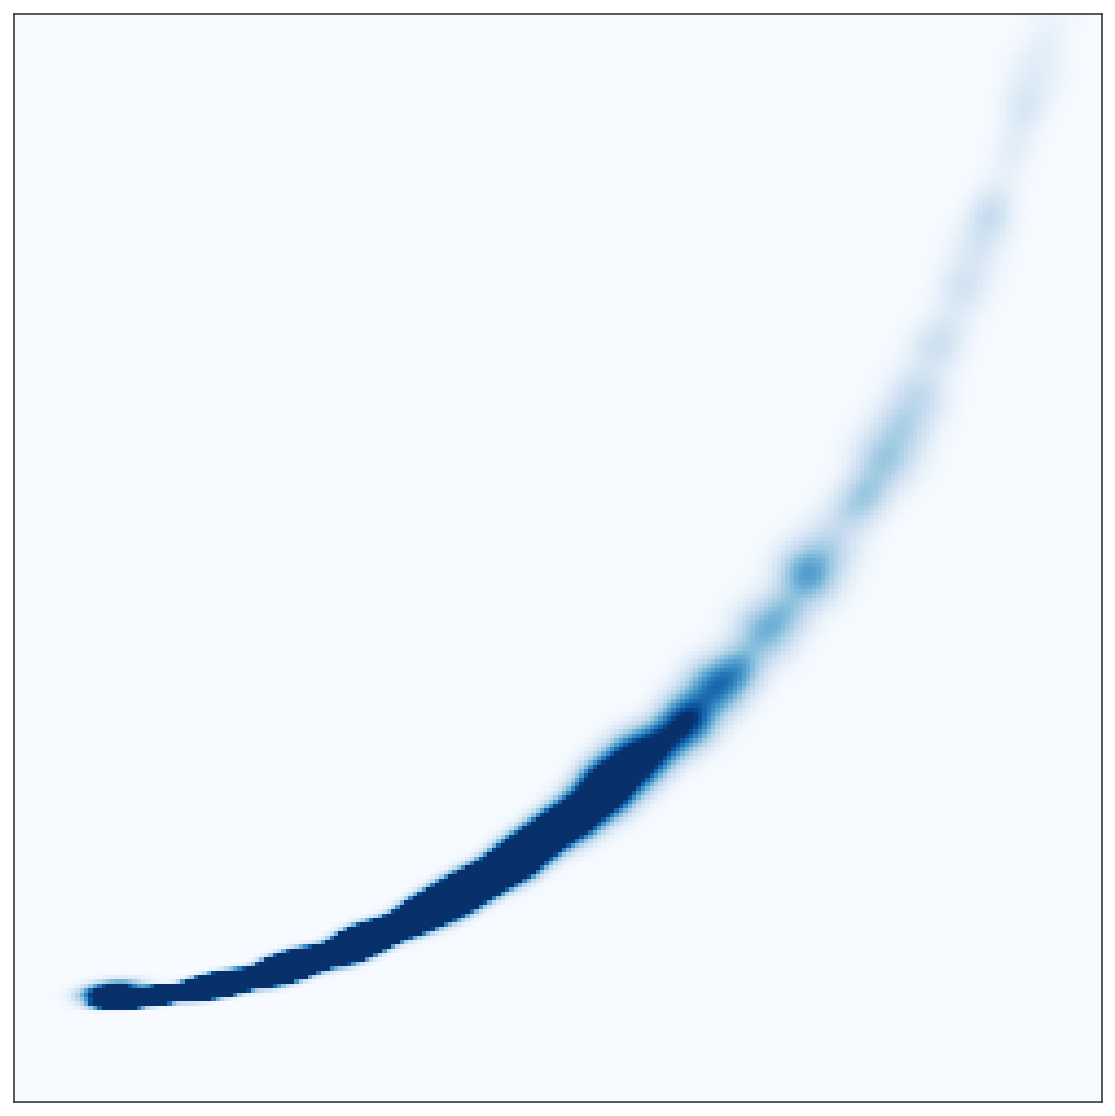

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.pcolormesh(xg, yg, H2,
              cmap='Blues', vmin=0, vmax=1e-2)
ax.set_aspect('equal')
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

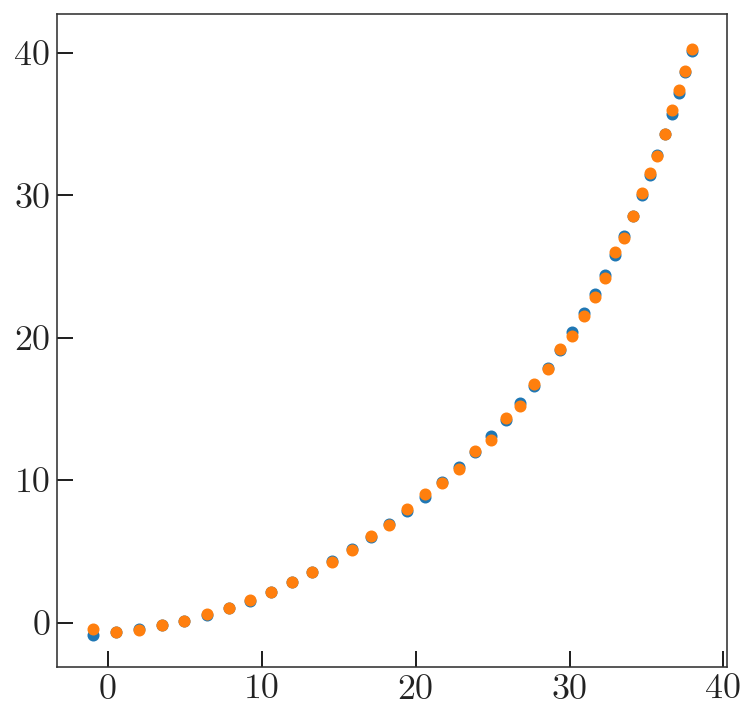

In [58]:
plt.scatter(dens_model.nodes[:, 0],
            dens_model.nodes[:, 1])

mu = model.get_mu(best_p)
plt.scatter(mu[:, 0], mu[:, 1])

In [60]:
# plt.plot(dens_model.nodes[:, 0],
#          dens_model.nodes[:, 1] - mu[:, 1])

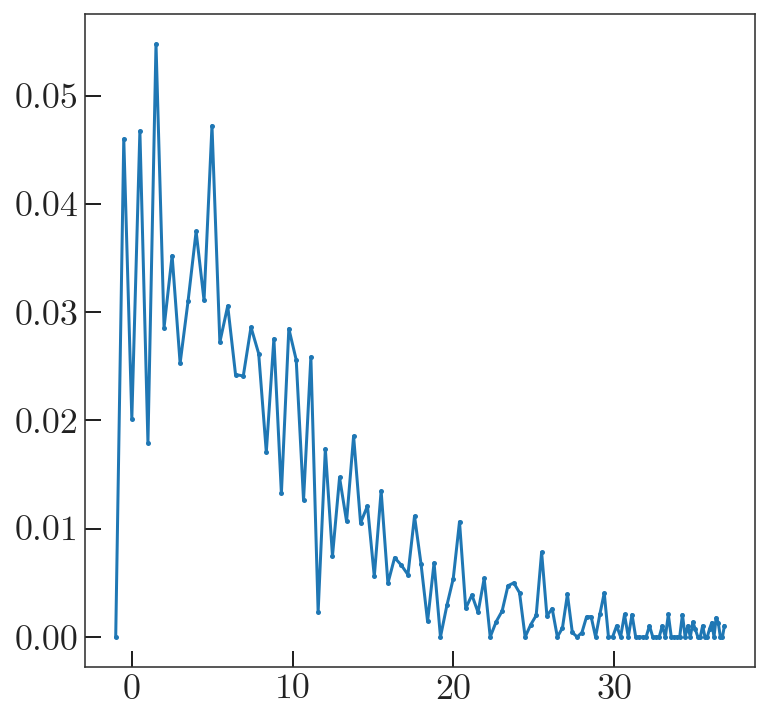

In [206]:
plt.plot(nodes[:, 0], ak)